# Computing planet fluxes

In [1]:
%matplotlib inline
import photometry as pt
from astropy import units as u
from astropy.coordinates import Angle
import numpy as np
from matplotlib import pyplot as plt
from astropy.time import Time

In [2]:
# initialize the planets
uranus = pt.GiantPlanet('Uranus')
neptune = pt.GiantPlanet('Neptune')

In [4]:
# compute neptune solid angle for one date, and uranus for two
neptune_omega = neptune.solid_angle(Time('2017-04-20T00:00:00.0'))
uranus_omega =  uranus.solid_angle(Time(['2015-10-15T00:00:00.0','2017-04-20T00:00:00.0']))

In [5]:
print("neptune solid angle: {}".format(neptune_omega))
print("uranus solid angle: {}".format(uranus_omega))

neptune solid angle: 9.044672375164236e-11 rad2
uranus solid angle: [  2.49967181e-10   2.06228857e-10] rad2


In [7]:
# Spectrum is not yet ready for multidim...
spec_uranus_2017 = uranus.spectrum(uranus_omega[1])
spec_uranus_2015 = uranus.spectrum(uranus_omega[0])

spec_neptune_2017 = neptune.spectrum(neptune_omega)

In [8]:
nika2mm = pt.Passband(file='2mm.NIKA2.pb')
nika1mmH = pt.Passband(file='1mmH.NIKA2.pb')
nika1mmV = pt.Passband(file='1mmv.NIKA2.pb')

In [9]:
print("Uranus fluxes in 2017:")
print('1mmH: {0:0.03f} | 2mm: {1:0.03f} | 1mmV: {2:0.03f}'.
          format(nika1mmH.fnu_ab(spec_uranus_2017).to(u.Jy),
                     nika2mm.fnu_ab(spec_uranus_2017).to(u.Jy),
                     nika1mmV.fnu_ab(spec_uranus_2017).to(u.Jy)))

Uranus fluxes:
1mmH: 36.752 Jy | 2mm: 15.002 Jy | 1mmV: 37.389 Jy


In [ ]:
print("Neptune fluxes in 2017:")
print('1mmH: {0:0.03f} | 2mm: {1:0.03f} | 1mmV: {2:0.03f}'.
          format(nika1mmH.fnu_ab(spec_neptune_2017).to(u.Jy),
                     nika2mm.fnu_ab(spec_neptune_2017).to(u.Jy),
                     nika1mmV.fnu_ab(spec_neptune_2017).to(u.Jy)))


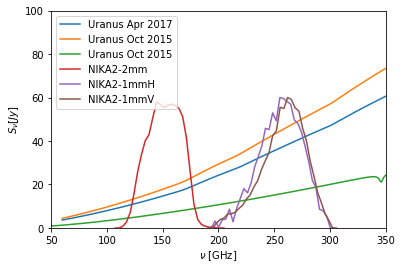

In [23]:
plt.plot(spec_uranus_2017.nu(u.GHz), spec_uranus_2017.fnu(u.Jy), label='Uranus Apr 2017')
plt.plot(spec_uranus_2015.nu(u.GHz), spec_uranus_2015.fnu(u.Jy), label='Uranus Oct 2015')
plt.plot(spec_neptune_2017.nu(u.GHz), spec_neptune_2017.fnu(u.Jy), label='Uranus Oct 2015')
plt.xlabel(r'$\nu$ [GHz]')
plt.ylabel(r'$S_{\nu} [Jy]$')
plt.axis([50, 350, 0, 100])
plt.plot(nika2mm.nu(u.GHz), nika2mm.y*60., label='NIKA2-2mm')
plt.plot(nika1mmH.nu(u.GHz), nika1mmH.y*60., label='NIKA2-1mmH')
plt.plot(nika1mmV.nu(u.GHz), nika1mmV.y*60., label='NIKA2-1mmV')
plt.legend(loc='upper left', frameon=True)



